# Demo of simulating disk in total intensity

This notebook assumes you have read and run `tutorial1_corgisim.ipynb`, which walks through simulating coronagraphic observations of an on-axis host star with off-axis companions. In Tutorial 1, the image was generated with the HLC coronagraph (a narrow-field mode).

Here, we adapt the same simulation framework to model an **extended source**: a circumstellar disk around the on-axis host star. We will:
- define a simple disk brightness distribution,
- propagate the combined star+disk scene through the coronagraph model, and
- visualize the final image to understand what a coronagraphic observation of a disk looks like in this mode.

In [1]:
#import necessary packages
from corgisim import scene, instrument, convolution
import matplotlib.pyplot as plt
import proper
import roman_preflight_proper
roman_preflight_proper.copy_here()

### 2D scene inputs: disk model + PRF cube

For an extended scene (star + disk), we provide:
- a **disk model FITS** file (2D image of the disk brightness distribution), and
- a **PRF cube** (pre-computed PRF/PSF cube).

We collect these paths and scaling parameters in a dictionary (`twoD_scene_info`) that is passed into the extended-scene simulation.

In [ ]:
# --- Disk path ---
disk_model_path = # Path to the FITS file

# --- PRF path ---
prf_path =  # Path to the PRF FITS file
# --- info needed for the extended scene simulation ---
twoD_scene_info = {
        'disk_model_path': disk_model_path,
        'prf_path': prf_path,
        'contrast': 16.0 # scaling factor for the disk model
        # 'flux unit': str, # to be added by Chen
    }


### Optics setup (same as tutorial 1)

The coronagraph/instrument configuration is unchanged from `tutorial1_corgisim.ipynb`.
The key difference in this notebook is the **input scene**: we now simulate an on-axis host star with an **extended 2D disk model** (via `twoD_scene_info`) rather than off-axis point companions.

Below, we:
1. define the host star properties,
2. initialize the scene using the extended disk inputs, and
3. configure the ROMAN CGI optical model (HLC by default)

In [3]:
# --- Host star properties ---
Vmag = 8                            # V-band magnitude of the host star
sptype = 'G0V'                      # Spectral type of the host star
ref_flag = False                    # if the target is a reference star or not, default is False
host_star_properties = {'Vmag': Vmag,
                        'spectral_type': sptype,
                        'magtype': 'vegamag',
                        'ref_flag': False}



# --- Initialize scene (extended 2D disk) ---
base_scene = scene.Scene(host_star_properties, twoD_scene_info=twoD_scene_info)

# --- Coronagraph / bandpass selection ---
# HLC band 1F (narrow field)
bandpass_corgisim = "1F"
cor_type = "hlc"
cases = ["3e-8"]
rootname = f"hlc_ni_{cases[0]}"
output_dim = 51

# # SPC-wide band 4 (wide field)
# bandpass_corgisim = "4F"
# cor_type = "spc-wide"
# cases = ["2e-8"]
# rootname = f"spc-wide_ni_{cases[0]}"
# output_dim = 201

cgi_mode = 'excam'

# --- Load DM solutions ---
dm1 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm1_v.fits' )
dm2 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm2_v.fits' )


# --- Optics keywords (same as Tutorial 1) ---
optics_keywords = {'cor_type':cor_type, 'use_errors':2, 'polaxis':10, 'output_dim':output_dim,\
                    'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2,'use_fpm':1, 'use_lyot_stop':1,  'use_field_stop':1 }
   
optics = instrument.CorgiOptics(cgi_mode, bandpass_corgisim, optics_keywords=optics_keywords, if_quiet=True)

CorgiOptics initialized with proper keywords.


### Generate the coronagraphic PSF of the on-axis host star

As in Tutorial 1, we first propagate the **on-axis host star** through the coronagraph to obtain its coronagraphic point-spread function (PSF).  
This PSF provides the stellar leakage pattern that will be combined with the extended disk emission in the next step.

Even though we are modeling a star + disk system, the stellar PSF is still computed separately and then used as part of the full scene propagation.

In [ ]:
# Generate coronagraphic PSF of the on-axis host star
# sim_scene: SimulatedImage object containing simulated images
sim_scene = optics.get_host_star_psf(base_scene) 

# Extract the stellar image from the simulation object
image_star_corgi = sim_scene.host_star_image.data

### Propagate the 2D disk scene through the coronagraph

We now simulate the disk as provided in a FITS file. Since no absolute photometric calibration is assumed for this template, the disk model is interpreted as a **relative intensity map** that is scaled by the user-defined factor (e.g., `contrast`) within the scene/simulation framework.

The extended emission is propagated through the coronagraph using a PRF-based convolution: each location in the disk template is mapped to the focal plane using the pre-computed, field-dependent PRF cube (with optional interpolation between PRFs).

This produces a simulated disk observation, including the effects of coronagraphic throughput and diffraction encoded in the PRFs. 

In [5]:
# Propagate the 2D disk scene through the coronagraph using PRF convolution
sim_scene = convolution.simulate_2d_scene(optics=optics, input_scene=base_scene, output_scene=sim_scene, interpolate_prfs=True)

# Disk-only contribution image
image_disk_corgi = sim_scene.twoD_image.data 

# Total (star + disk)
image_tot_corgi = image_star_corgi + image_disk_corgi

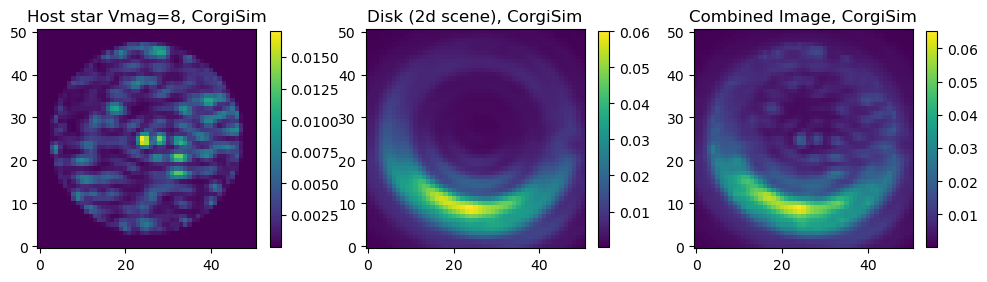

In [6]:
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(image_star_corgi,origin='lower')
plt.title('Host star Vmag={0}, CorgiSim'.format(Vmag))
co = plt.colorbar(shrink=0.7)

plt.subplot(132)
plt.imshow(image_disk_corgi,origin='lower')
plt.title('Disk (2d scene), CorgiSim')
co = plt.colorbar(shrink=0.7,)

plt.subplot(133)
plt.imshow(image_tot_corgi,origin='lower')
plt.title('Combined Image, CorgiSim')
co = plt.colorbar(shrink=0.7)

In [ ]:
# Checking the 2D_image sim_info after the convolution
sim_scene.twoD_image.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   51                                                  
NAXIS2  =                   51                                                  
EXTEND  =                    T                                                  
COMMENT Simulated data with metadata below:                                     
COMMENT host_star_sptype : G0V                                                  
COMMENT host_star_Vmag : vegamag                                                
COMMENT host_star_magtype : vegamag                                             
COMMENT ref_flag : False                                                        
COMMENT cgi_mode : excam                                                        
COMMENT cor_type : hlc      

### Generate a detector realization (EMCCD + exposure time)

We now generate a **detector-level image** by applying an EMCCD detector model, including the specified EM gain and exposure time (and optional noise sources such as cosmic rays).

In [8]:
# --- Simulate detector noise / detector realization ---
gain =100
emccd_keywords ={'em_gain':gain, 'cr_rate':0}


detector = instrument.CorgiDetector(emccd_keywords)
exptime = 10000
sim_scene = detector.generate_detector_image(sim_scene,exptime)

# Detector-level image
image_tot_corgi_sub= sim_scene.image_on_detector.data

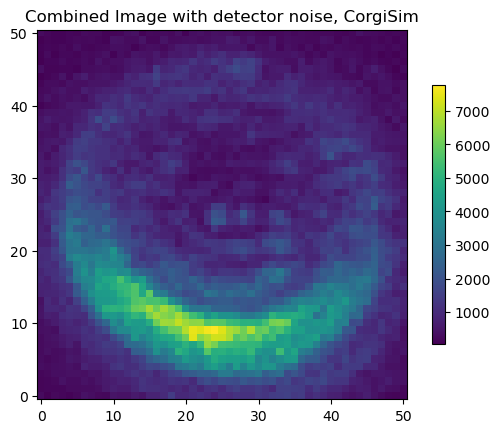

In [9]:
#plot image with detector noise
plt.imshow(image_tot_corgi_sub,origin='lower')
plt.title('Combined Image with detector noise, CorgiSim')

co = plt.colorbar(shrink=0.7)

In [10]:
# Generate a full-frame detector image
sim_scene = detector.generate_detector_image(sim_scene,exptime,full_frame=True,loc_x=512, loc_y=512)

# The full-frame detector image is returned as the second element
image_tot_corgi_full = sim_scene.image_on_detector[1].data

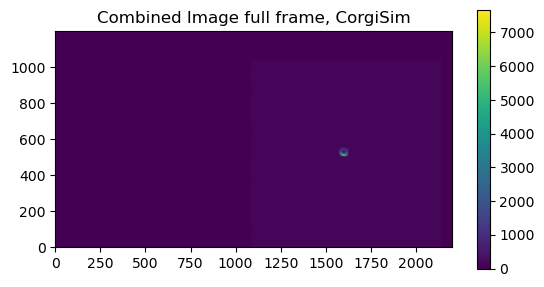

In [11]:
# plot full frame detector image
plt.imshow(image_tot_corgi_full,origin='lower')
plt.title('Combined Image full frame, CorgiSim')

co = plt.colorbar(shrink=0.7)

In [ ]:
# Checking the 2D_image sim_info after generating full-frame detector image
sim_scene.twoD_image.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   51                                                  
NAXIS2  =                   51                                                  
EXTEND  =                    T                                                  
COMMENT Simulated data with metadata below:                                     
COMMENT host_star_sptype : G0V                                                  
COMMENT host_star_Vmag : vegamag                                                
COMMENT host_star_magtype : vegamag                                             
COMMENT ref_flag : False                                                        
COMMENT cgi_mode : excam                                                        
COMMENT cor_type : hlc      